**Autor:**   
Lilian Rebeca Carrera Lemus


# Laboratorio No.3

Para este laboratorio deberá utilizar Tensorow/Keras para desarrollar un clasificador binario el cual permita realizar la clasificación de las observaciones proporcionadas (dataset de gatos y perros).
Como métrica de referencia deberá generar un accuracy mnimo de 0.8, la idea del laboratorio es que usted entienda como funcionan las diferentes capas que forman una red neuronal convolucional y como esta puede ajustarse o modificar para mejorar los resultados de una predicción.  

In [25]:
#El primer paso es importar librerías necesarias
import tensorflow.keras as ks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense #Creación de capas con neuronas
from tensorflow.keras.layers import Conv2D #Para trabajar la convolución 
from tensorflow.keras.layers import MaxPooling2D #Max pooling
from tensorflow.keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot  as plt
import cv2
import numpy as np

In [15]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [16]:
#Se va a usar la GPU de la máquina para mejorar el tiempo en el entrenamiento de la red
#Determinar primero la existencia de una GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16876193214614491500
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15934722359616387396
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5195809392484359483
physical_device_desc: "device: XLA_GPU device"
]


In [17]:
#Si se ha detectado una GPU, se procede a la configuración y utilizarla en la sesión
config = tf.compat.v1.ConfigProto( )
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

## Definición del Modelo de Red Convolucional

Este modelo está divido en dos partes, la primera es la red convolucional, que cuenta con dos capas convolucionales, que realizan la extracción de features y detectan patrones en las imagenes y la segunda es la capa completamente conectada (fully connected), la cual se encarga de realizar la clasificación con base a los patrones detectados en la red convolucional.

In [18]:
#Definimos una estructura base para agregar las capas de la red, la cual se ejecutará en secuencia
cnn = Sequential()  

#Agregamos la primera capa convolucional, con los siguientes parámetros:
#filtros = 32, que significa que se realizarán 32 convoluciones
#tamaño de los filtros = 3*3
#Definimos la entrada = imagenes de 64*64 y de 3 canales (ya que son imágenes a  color)
#Función de activación = ReLu para que cambie los números negativos a 0
#Por default si no definimos el padding, utiliza "same"
cnn.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(64,64,3), activation="relu"))

#Agregamos capa de maxpooling asociada a la primera capa convolucional
#Para reducir la dimensionalidad de la imagen resultante de la capa convolucional con la mejor versión 
cnn.add(MaxPooling2D(pool_size=(4,4)))

#Agregamos la segunda capa convolucional, con los siguientes parámetros:
#filtros = 24, que significa que se realizarán 24 convoluciones
#tamaño de los filtros = 3*3
#Definimos la entrada = imagenes de 64*64 y de 3 canales (ya que son imágenes a  color)
#Función de activación = ReLu para que cambie los números negativos a 0
#Por default si no definimos el padding, utiliza "same"
cnn.add(Conv2D(filters=24,  kernel_size=(3, 3), input_shape=(64, 64, 3), activation='relu'))

#Segunda Capa de maxpooling, como definimos una segunda capa convolucional, agregamos su respectiva capa de maxpooling
cnn.add(MaxPooling2D(pool_size=(4, 4)))

#Capa de Flattening
#El resultado de maxpooling anterior lo aplana y lo vuelve un vector
cnn.add(Flatten()) 

#Red neuoranal -> Fully connected
#En esta capa no definimos el input size porque no es la primera
#units = cantidad de neuronas
#Para definir la cant. de neuronas = (40 entradas + cant. salidas)/2 o bien trabajar con potencias de 2.
cnn.add(Dense(units=128, activation="relu"))

#Capa de salida - Clasificación binaria
#La definición de esta capa depende del problema a resolver
#Como en este caso la salida es clasificación binaria solo necesitamos una neurona
#Función de activación = Sigmoid es mejor en este caso, ya que es más facil de interpretar la salida como una probabilidad
cnn.add(Dense(units=1, activation="sigmoid"))

### Compilar la Red  

En este paso es donde definiremos los elementos de como vamos a resolver el problema.

In [19]:
#optimizer = función de optimización para resolver el problema, en este caso Adam
#Adam se recomienda para estos casos, ya que, es más eficiente que SGD
#loss= función para evaluar si mi solución es adecuada
#Metrica para medir como está funcionando el algoritmo, pueden ser varias
cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

## Preprocesamiento de las imágenes  
El siguiente paso es formatear los datos para el entrenamiento y las pruebas.

In [23]:
#Transformaciones para el entrenamiento
#Hacer variaciones en las imagenes para que sea mejor después para predecir y reducir el overfitting, es decir enriquecer la entrada
train_datagen = ImageDataGenerator(
    rescale=1./255., 
    shear_range=0.2, #Giros aleatorios
    zoom_range=0.2, #Zooms aleatorios
    horizontal_flip=True 
)

#Para los datos de test
test_datagen = ImageDataGenerator(
    rescale=1./255.
)

strDataTrain = "training_set"
strDataTest= "test_set"

#El siguiente paso es formatear las imagenes
#Ya que todas tienen diferentes tamaños y caracteristicas

#configuración de imagenes de entrada para train
train_set = train_datagen.flow_from_directory(
    strDataTrain, 
    target_size=(64, 64), 
    batch_size=32, 
    class_mode='binary'
)

#configuración de imagenes de entrada para test
test_set = test_datagen.flow_from_directory(
    strDataTest, 
    target_size=(64, 64), 
    batch_size=32, 
    class_mode='binary'
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Configuración del Entrenamiento

In [24]:
#El siguiente paso es definir los mejores parámetros para el entrenamiento, de modo que se cumpla con que el error baje
#y el acurracy esté de acuerdo a los límites definidos en el problema
#Se realizará el entrenamiento y validación de una vez
#Para el entrenamiento en este caso se definieron 5 epochs, usando 8000 imágenes en cada uno
#Para la validación son los 5 epochs, usando 2000 imágenes en cada uno.
cnn.fit(train_set, 
       steps_per_epoch=8000, 
       epochs=5, 
       validation_data=test_set, 
       validation_steps=2000, 
       verbose=1)

Epoch 1/5
8000/8000 [==============================] - ETA: 0s - batch: 3999.5000 - size: 32.0000 - loss: 0.4336 - acc: 0.7930WARNING:tensorflow:From C:\Users\Rebeca\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
8000/8000 [==============================] - 935s 117ms/step - batch: 3999.5000 - size: 32.0000 - loss: 0.4336 - acc: 0.7930 - val_loss: 0.4151 - val_acc: 0.8125
Epoch 2/5
8000/8000 [==============================] - 959s 120ms/step - batch: 3999.5000 - size: 32.0000 - loss: 0.2987 - acc: 0.8692 - val_loss: 0.4167 - val_acc: 0.8265
Epoch 3/5
8000/8000 [==============================] - 978s 122ms/step - batch: 3999.5000 - size: 32.0000 - loss: 0.2225 - acc: 0.9061 - val_loss: 0.5286 - val_acc: 0.8201
Epoch 4/5

Con estos parámetros en el entranamiento se logró un acurracy de 94.36, el cuál es mayor al indicado.

## Realizar Predicciones

In [34]:
#El siguiente paso es definir una función para realizar las predicciones usando el modelo entrenado anteriormente
def predecir(dir_imagen, modelo):
    
    imagen = cv2.imread(dir_imagen)
    #Ajustar tamaño de imagen de entrada, de acuerdo a lo definido en el modelo
    imagen = cv2.resize(imagen, (64,64))
    
    #Lista de posibles clases del modelo
    lista_clases = [*(train_set.class_indices).keys()]
    
    #Obtener la prediccion, es decir, clase a la que pertenece la imagen de entrada
    prediccion = modelo.predict_classes(np.array([imagen]))
    prediccion = lista_clases[prediccion[0][0]]
    
    #Mostrar resultado de la imágen de entrada
    img = cv2.imread(dir_imagen)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title(prediccion)
    plt.imshow(img)


Probamos el modelo, con las imágenes proporcionadas para predicción

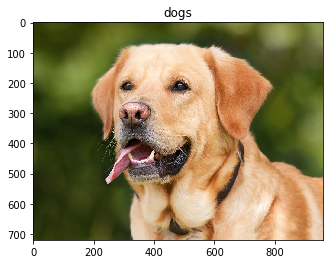

In [35]:
predecir('single_prediction/cat_or_dog_1.jpg', cnn)

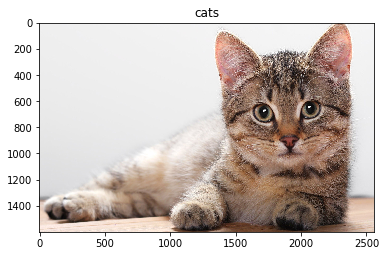

In [36]:
predecir('single_prediction/cat_or_dog_2.jpg', cnn)